## 使用 LSTM 拟合正余弦函数

In [1]:
# 导入必要的库
import numpy as np  # 构建数据
# 搭建模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tqdm import tqdm  # 打印进度条

import matplotlib.pyplot as plt  # 可视化
%matplotlib inline

### 1. 构造数据集

这一模块将使用 numpy 构造时间序列数据，主要有两个步骤：

1. 定义正弦函数 (余弦函数)
2. 选定历史数据窗口大小构造时序数据

In [21]:
def ground_func(x):
    """sine/cosine function.
    
    Args:
        x: numpy.ndarray
    
    return:
        sin(x) or cos(x)
    """
    ######## your code ~ 1 line ########
    y = np.sin(x)
    ######## your code ########
    return y

In [64]:
def build_data(sequence_data, n_steps):
    """Use sine function data to build X, y.
    
    Args:
        sine_data: numpy.ndarray
        n_steps: history data window size
    
    return:
        X: numpy.ndaray, y: numpy.ndarray
    """
    # init 
    X, y = [], []
    
    seq_len = len(sequence_data)
    for start_idx in tqdm(range(seq_len), total=seq_len):
        end_idx = start_idx + n_steps
        
        if end_idx >= seq_len:
            break
        
        ######## your code ~ 2 line ########
        # hits:
        #     1. sequence data in slice(start_idx, end_idx) as current x
        #     2. end index data as current y
        cur_x = sequence_data[start_idx:end_idx]
        cur_y = sequence_data[end_idx]
        ######## your code ########
        
        X.append(cur_x)
        y.append(cur_y)
        
    X = np.array(X)
    y = np.array(y)
    
    # *X.shape get number of examples and n_steps, but LSTM need inputs like (batch, n_steps, n_features),
    # here we only have 1 feature
    X = X.reshape(*X.shape, 1)
        
    return X, y

In [65]:
# 构造原始正弦/余弦函数序列
xaxis = np.arange(-50 * np.pi, 50 * np.pi, 0.1)
sequence_data = ground_func(xaxis)
len(sequence_data)  # 查看数据量

3142

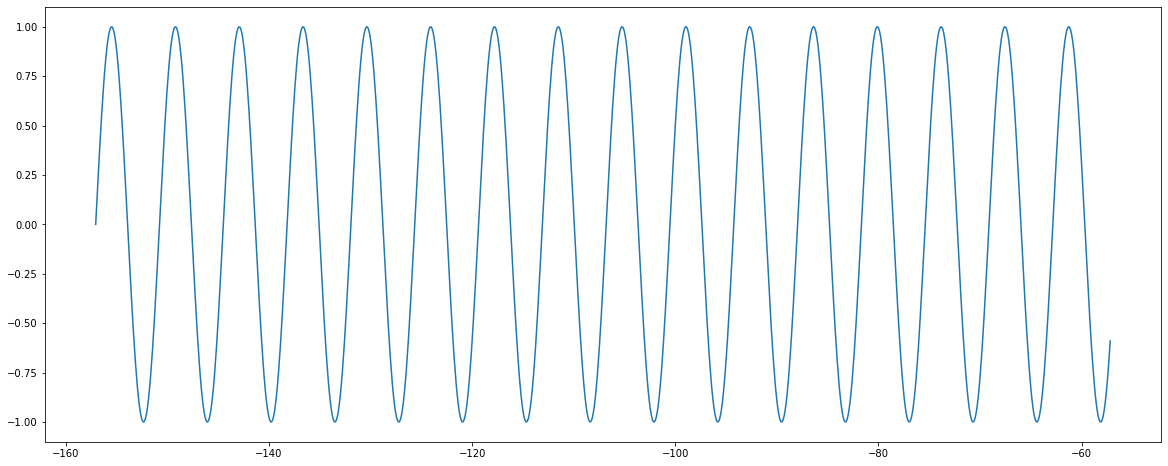

In [66]:
# 取 1000 个数据进行可视化
plt.figure(figsize=(20, 8))
plt.plot(xaxis[:1000], sequence_data[:1000]);

In [67]:
n_steps = 20  # 可以尝试更改
X, y = build_data(sequence_data, n_steps)
X.shape, y.shape  # 查看 X, y 的维度信息

 99%|█████████▉| 3122/3142 [00:00<00:00, 935396.61it/s]


((3122, 20, 1), (3122,))

### 2. 搭建模型

本模块基于 keras 中的 LSTM、Dense 层搭建时序模型，需要注意以下几点：
1. 选择合适的 hidden size
2. 选择合适的激活函数，比如 relu、tanh
3. 优化器选择 sgd、adam 等等
3. 损失函数选择交叉熵损失函数(cross_entropy) 还是均方误差(mse) 等等 

In [68]:
def create_model():
    """Build a LSTM model fit sine/cosine function.
    
    hints: 
        1. a LSTM fit time pattern (ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
        2. a Dense for regression (ref: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
    """
    ######## your code ~ 5 line ########
    model = Sequential()
    model.add(Input(shape=(20, 1)))
    model.add(LSTM(32, activation="tanh"))
    model.add(Dense(1, activation="tanh"))
    model.compile(optimizer='adam', loss='mse')	
    ######## your code ########
    return model

In [69]:
# 初始化模型并打印相关信息
model = create_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### 3. 模型训练

Epoch 1/25
98/98 [==============================] - 2s 17ms/step - loss: 0.1366
Epoch 2/25
98/98 [==============================] - 2s 16ms/step - loss: 0.0045
Epoch 3/25
98/98 [==============================] - 2s 16ms/step - loss: 8.3464e-04
Epoch 4/25
98/98 [==============================] - 2s 16ms/step - loss: 1.9585e-04
Epoch 5/25
98/98 [==============================] - 2s 16ms/step - loss: 1.0087e-04
Epoch 6/25
98/98 [==============================] - 2s 15ms/step - loss: 5.4695e-05
Epoch 7/25
98/98 [==============================] - 1s 15ms/step - loss: 5.6007e-05
Epoch 8/25
98/98 [==============================] - 2s 17ms/step - loss: 3.3704e-05
Epoch 9/25
98/98 [==============================] - 2s 19ms/step - loss: 3.2815e-05
Epoch 10/25
98/98 [==============================] - 1s 14ms/step - loss: 3.0080e-05
Epoch 11/25
98/98 [==============================] - 1s 15ms/step - loss: 2.7249e-05
Epoch 12/25
98/98 [==============================] - 1s 15ms/step - loss: 1.1776e-

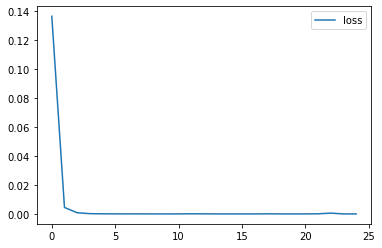

In [70]:
# 尝试更改 epochs ，加入 callbacks，例如 EarlyStopping (https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
history = model.fit(X, y, batch_size=32, epochs=25, verbose=1)
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")  # 画出损失图像

### 4. 预测

本模块使用和训练数据不同的函数构造测试数据来验证模型的泛化性能，主要有以下几个步骤：
1. 定义新的函数 (sine/cosine)
2. 利用训练好的模型进行预测
3. 将模型预测结果和真实值进行可视化对比

In [71]:
def test_func(x):
    """sine/cosine function, different from ground_func above.
    
    Args:
        x: numpy.ndarray
    
    return:
        sin(x) or cos(x)
    """
    ######## your code ~ 1 line ########
    y = np.cos(x)
    ######## your code ########
    return y

In [72]:
test_xaxis = np.arange(0, 10 * np.pi, 0.1)

test_sequence_data = test_func(test_xaxis)

# 利用初始的 n_steps 个历史数据开始预测，后面的数据依次利用预测出的数据作为历史数据进行进一步预测
y_preds = test_sequence_data[:n_steps]

# 逐步预测
for i in tqdm(range(len(test_xaxis) - n_steps)):
    model_input = y_preds[i: i + n_steps]
    model_input = model_input.reshape((1, n_steps, 1))
    ######## your code ~ 1 line ########
    y_pred = model.predict(model_input,verbose=0)
    ######## your code ########
    y_preds = np.append(y_preds, y_pred)

100%|██████████| 295/295 [00:12<00:00, 24.51it/s]


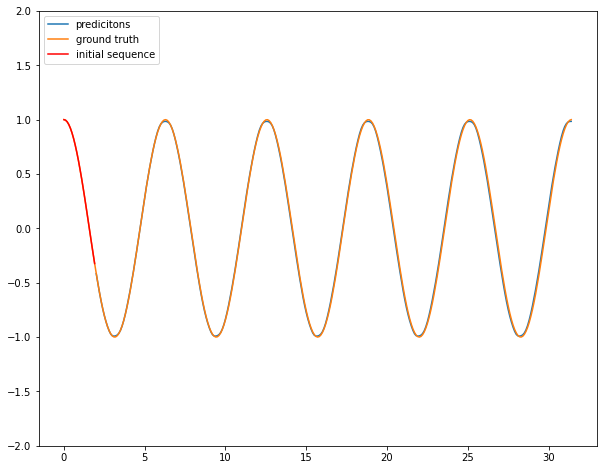

In [73]:
# 可视化
plt.figure(figsize=(10, 8))
plt.plot(test_xaxis[n_steps:], y_preds[n_steps:], label="predicitons")
plt.plot(test_xaxis, test_sequence_data, label="ground truth")
plt.plot(test_xaxis[:n_steps], y_preds[:n_steps], label="initial sequence", color="red")
plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()